# ECH - Encuesta continua de hogares 2020

## Objetivos

En esta investigación buscamos determinar cuánto afecta el nivel educativo, la cantidad de hijos y otros indicadores, a la inserción en el mercado laboral de las mujeres uruguayas. Luego de un análisis principal de la base para conocer el contexto general de la investigación, intentaremos crear un algoritmo de clasificación para entender la influencia de distintas variables categóricas en un resultado determinado.

### Librerias a utilizar

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(30,8)})

### Importar dataset y seleccionar atributos de análisis principales.

Para leer el archivo es necesario contar con la libreria _pyreadstat_

In [2]:
df = pd.read_spss('HyP_2020_Terceros.sav')

df = df.rename(columns={
    'numero': 'id_hogar',
    'e26': 'sexo',
    'e27': 'edad',
    'e563': 'genero',
    'e29_6': 'ascendencia',
    'e30': 'parentesco',
    'pobpcoac': 'estado_laboral',
    'g126_1': 'sueldo',
    'f99': 'busca_otro_trabajo',
    'f72_2': 'actividad',
    'e49_CV': 'asistencia a enseñanza',
    'e49': 'asistencia alguna vez a enseñanza',
    'e193': 'edu preescolar',
    'e197': 'edu primaria',
    'e201': 'edu media',
    'e212': 'edu técnica',
    'e215': 'edu mag prof',
    'e218': 'edu univ o simil',
    'e221': 'edu terciario no uni',
    'e224': 'edu posgrado'
    })

df = df[[
    'id_hogar', 
    'sexo', 
    'edad', 
    'genero', 
    'ascendencia', 
    'parentesco', 
    'estado_laboral', 
    'nper', 
    'sueldo', 
    'busca_otro_trabajo',
    'actividad',
    'asistencia alguna vez a enseñanza',
    'edu preescolar',
    'edu primaria',
    'edu media',
    'edu técnica',
    'edu univ o simil',
    'edu terciario no uni',
    'edu posgrado',
    'edu mag prof',
    ]]

df['nper'] = df['nper'].astype('category')
df['sexo'] = df['sexo'].astype('category')

## Primera exposición a los datos

In [3]:
df.sample(5)

,id_hogar,sexo,edad,genero,ascendencia,parentesco,estado_laboral,nper,sueldo,busca_otro_trabajo,actividad,asistencia alguna vez a enseñanza,edu preescolar,edu primaria,edu media,edu técnica,edu univ o simil,edu terciario no uni,edu posgrado,edu mag prof
84012,4480,1.0,58.0,Varón,Asiática o amarilla,Jefe/a de hogar,Ocupados,1.0,0.0,No,Otras actividades complementarias de transporte,Sí,"Sí, asistió","Sí, asistió","Sí, asistió",No asistió,0.0,0.0,0.0,0.0
93976,48534,2.0,2.0,0.0,Blanca,Hijo/a de ambos,Menor 14 años,5.0,0.0,0.0,,No,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123577,7608,1.0,51.0,Varón,Blanca,Esposo/a o compañero/a,Ocupados,2.0,0.0,No,Otros transportes terrestres de pasajeros,Sí,"Sí, asistió","Sí, asistió","Sí, asistió",No asistió,0.0,0.0,0.0,0.0
73441,40228,2.0,25.0,Mujer,Blanca,Jefe/a de hogar,"Inactivo, realiza los quehaceres del hogar",1.0,0.0,0.0,,Sí,"Sí, asistió","Sí, asistió","Sí, asistió",No asistió,0.0,0.0,0.0,0.0
53795,32244,2.0,57.0,Mujer,Blanca,Esposo/a o compañero/a,"Inactivo, realiza los quehaceres del hogar",2.0,0.0,0.0,,Sí,No asistió,"Sí, asistió","Sí, asistió",No asistió,0.0,0.0,0.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145166 entries, 0 to 145165
Data columns (total 20 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   id_hogar                           145166 non-null  object  
 1   sexo                               145166 non-null  category
 2   edad                               145166 non-null  float64 
 3   genero                             145166 non-null  category
 4   ascendencia                        145166 non-null  category
 5   parentesco                         145166 non-null  category
 6   estado_laboral                     145166 non-null  category
 7   nper                               145166 non-null  category
 8   sueldo                             145166 non-null  float64 
 9   busca_otro_trabajo                 145166 non-null  category
 10  actividad                          145166 non-null  category
 11  asistencia alguna vez a en

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
edad,145166.0,41.179684,23.657247,0.0,20.0,42.0,60.0,98.0
sueldo,145166.0,9711.315577,20269.848604,0.0,0.0,0.0,15000.0,600000.0


In [6]:
df['genero'].value_counts()

Mujer                    69037
Varón                    57429
0.0                      18571
Sin dato                    78
Mujer trans                 29
Varón trans                 14
Otra                         6
No sabe / No contesta        2
Name: genero, dtype: int64

### Ascendencia

In [7]:
asc_princ_porcentage = df['ascendencia'].value_counts() / len(df['ascendencia']) * 100

asc_princ_porcentage

Blanca                 69.510767
Asiática o amarilla    23.261645
Afro o negra            3.583484
Sin dato                2.384856
Indígena                1.244782
Otra                    0.014466
Name: ascendencia, dtype: float64

### Género

In [8]:
df['genero'].value_counts() / len(df['genero']) * 100

Mujer                    47.557279
Varón                    39.560916
0.0                      12.792940
Sin dato                  0.053732
Mujer trans               0.019977
Varón trans               0.009644
Otra                      0.004133
No sabe / No contesta     0.001378
Name: genero, dtype: float64

## Estudio de la composición de los hogares uruguayos

### Cantidad de personas que conforman un grupo familiar

In [9]:
familia = pd.pivot_table(df, index='id_hogar', columns='parentesco',values=['nper'], aggfunc='count')

familia['totales'] = familia.apply(lambda x:x.sum(), axis=1)

familia = familia.sort_values(by='totales', ascending=False)

familia['totales'].value_counts()

2     18429
1     15749
3     11547
4      8634
5      2870
6       887
7       267
8       134
9        44
10       11
12       10
11        8
13        3
16        1
Name: totales, dtype: int64

## Organización familiar

In [10]:
df['parentesco'].value_counts()

Jefe/a de hogar                            58021
Esposo/a o compañero/a                     31354
Hijo/a de ambos                            27083
Hijo/a solo del jefe/a                     15987
Nieto/a                                     4233
Hijo/a solo del esposo/a compañero/a        2288
Padre/madre                                 1601
Hermano/a                                   1070
Otro pariente                                888
Yerno/nuera                                  875
Otro no pariente                             865
Suegro/a                                     412
Sin dato                                     316
Cuñado/a                                     149
Servicio doméstico o familiar del mismo       24
Name: parentesco, dtype: int64

<AxesSubplot:ylabel='sexo'>

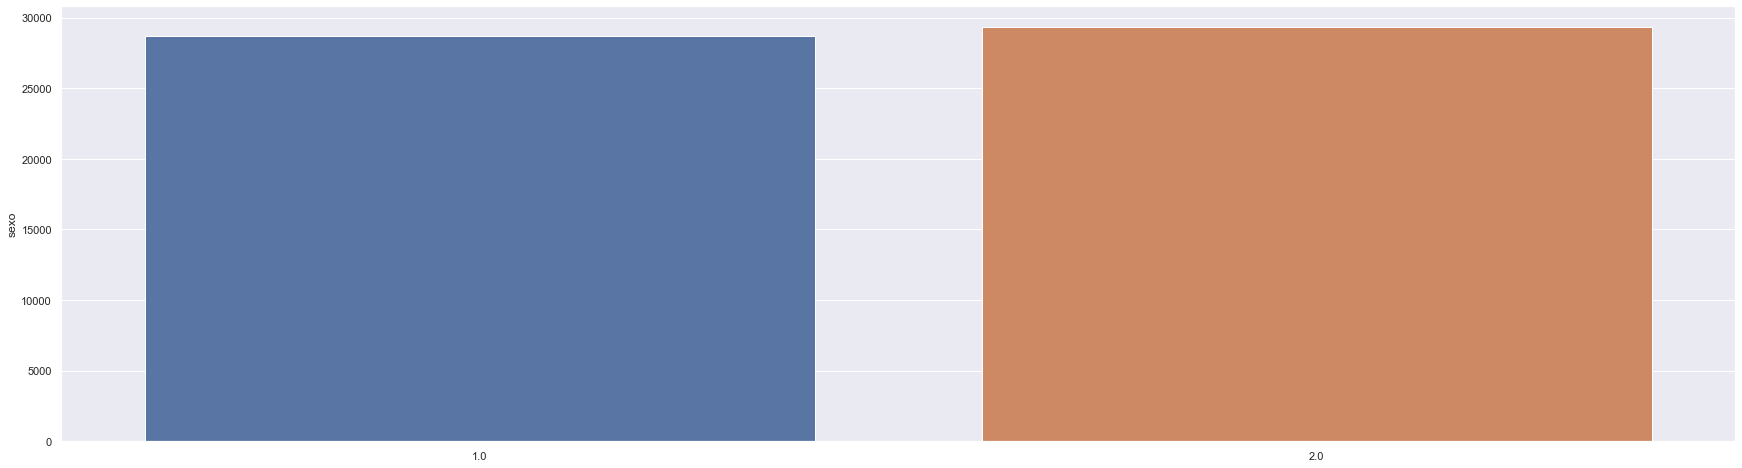

In [11]:
jefes_sexo = df[df['parentesco'].str.contains('Jefe')]['sexo'].value_counts()

sns.barplot(x=jefes_sexo.index, y=jefes_sexo)

Podemos observar que hay una distribución equitativa entre jefes de familia y sexo

## Situación laboral

In [12]:
df['estado_laboral'].value_counts()

Ocupados                                      63750
Inactivo, jubilado                            24536
Menor 14 años                                 22473
Inactivo, estudiante                          11835
Inactivo, realiza los quehaceres del hogar     7888
Inactivo, pensionista                          5805
Desocupados propiamente dichos                 5227
Inactivo, otro                                 1733
Desocupados BT1V                               1000
Inactivo, rentista                              495
Desocupados en seguro de desempleo              424
Name: estado_laboral, dtype: int64

<AxesSubplot:xlabel='estado_laboral', ylabel='count'>

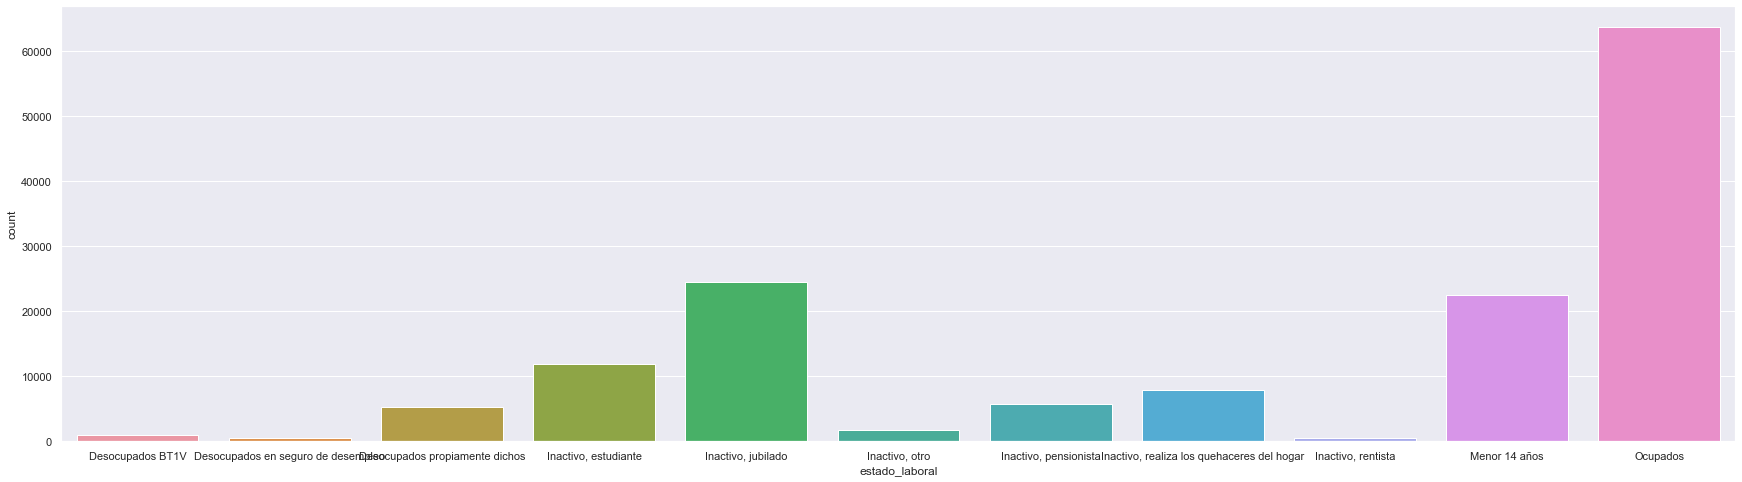

In [13]:
sns.countplot(x=df['estado_laboral'])

In [14]:
df['estado_laboral'].value_counts() / len(df['estado_laboral']) * 100

Ocupados                                      43.915242
Inactivo, jubilado                            16.902029
Menor 14 años                                 15.480898
Inactivo, estudiante                           8.152735
Inactivo, realiza los quehaceres del hogar     5.433779
Inactivo, pensionista                          3.998870
Desocupados propiamente dichos                 3.600705
Inactivo, otro                                 1.193806
Desocupados BT1V                               0.688867
Inactivo, rentista                             0.340989
Desocupados en seguro de desempleo             0.292079
Name: estado_laboral, dtype: float64

In [15]:
df.groupby(by='estado_laboral').mean()

,edad,sueldo
estado_laboral,,
Desocupados BT1V,20.338000,0.000000
Desocupados en seguro de desempleo,37.865566,2287.735849
Desocupados propiamente dichos,34.348766,1062.989286
"Inactivo, estudiante",17.600253,56.501901
"Inactivo, jubilado",72.474731,90.880665
"Inactivo, otro",35.807848,284.520485
"Inactivo, pensionista",63.898536,16.830319
"Inactivo, realiza los quehaceres del hogar",48.915314,271.754564
"Inactivo, rentista",57.296970,105.858586


<AxesSubplot:xlabel='ascendencia', ylabel='sueldo'>

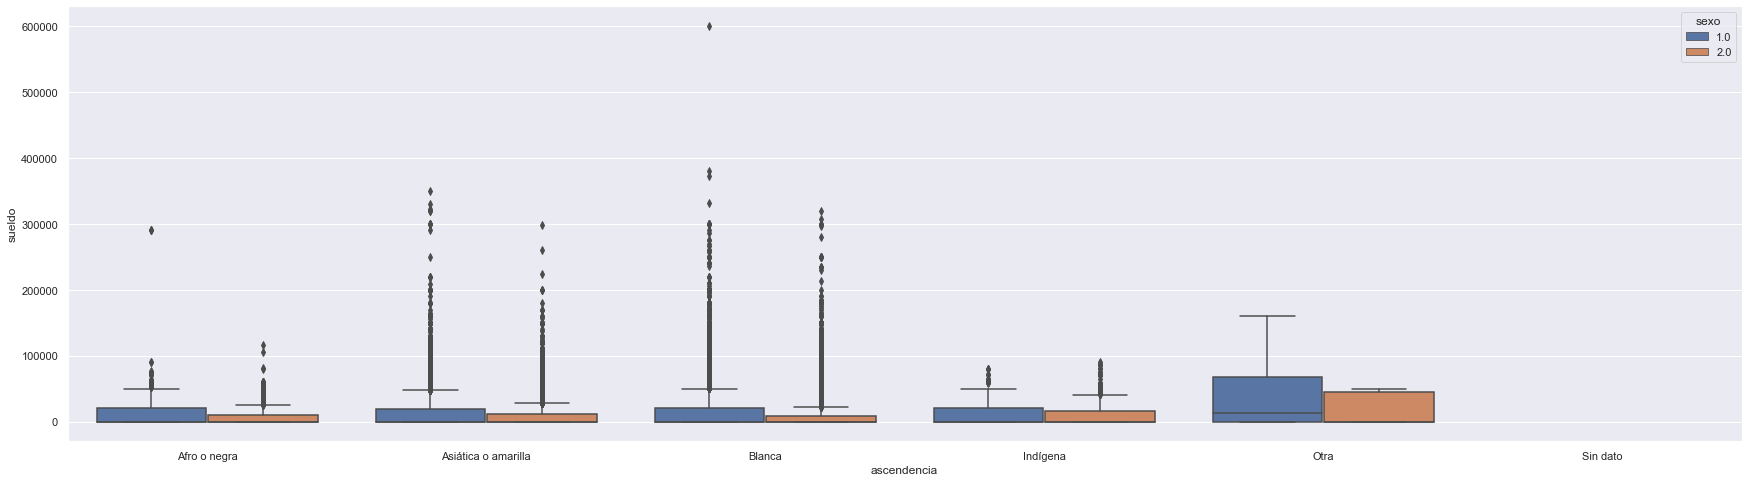

In [16]:
df = df[~df['ascendencia'].str.contains('Sin dato')]

sns.boxplot(data=df, x='ascendencia', y='sueldo', hue='sexo')

<AxesSubplot:xlabel='edad', ylabel='sueldo'>

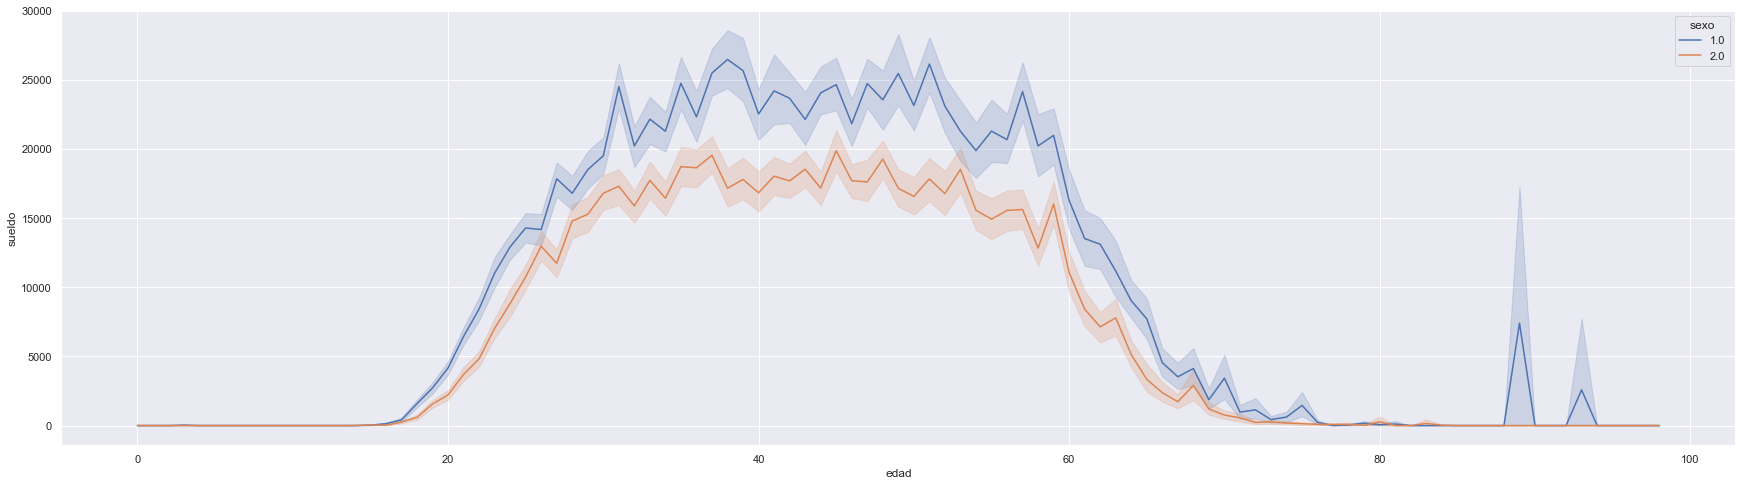

In [17]:
sns.lineplot(data=df, x='edad', y='sueldo',hue='sexo')

## Comienzo de análisis más profundo. 

En este punto nos empezamos a centrar en las madres, jefas de hogares.

In [18]:
df['parentesco_num'] = df['parentesco'].cat.codes

df[['parentesco_num', 'parentesco']].value_counts()

parentesco_num  parentesco                             
6               Jefe/a de hogar                            58008
1               Esposo/a o compañero/a                     30889
3               Hijo/a de ambos                            26240
5               Hijo/a solo del jefe/a                     15340
7               Nieto/a                                     3784
4               Hijo/a solo del esposo/a compañero/a        2181
10              Padre/madre                                 1440
2               Hermano/a                                    987
14              Yerno/nuera                                  787
9               Otro pariente                                783
8               Otro no pariente                             749
13              Suegro/a                                     363
0               Cuñado/a                                     130
11              Servicio doméstico o familiar del mismo       23
dtype: int64

In [19]:
mask = df['parentesco_num'].isin([3,5,6])
df = df[mask]

df['es_madre'] = np.NaN
df['es_madre'] = df['es_madre'].apply(lambda x:'madre').where(df['parentesco_num'] == 6).where(df['sexo'] == 2)

### Empezamos a centrarnos en las hogares monomarentales

In [20]:
# Eliminamos hogares con jefes de hogar masculinos
df_madre_y_familia = df.copy().drop(labels=list(df.loc[(df['sexo'] == 1) & (df['parentesco_num'] == 6)].index))

#Creamos una columna que cuenta la cantidad de hijos por grupo familiar
df_madre_y_familia['hijos'] = df_madre_y_familia.groupby('id_hogar')['id_hogar'].transform('count') - 1

df_madre_y_familia.sample(5)

,id_hogar,sexo,edad,genero,ascendencia,parentesco,estado_laboral,nper,sueldo,busca_otro_trabajo,...,edu primaria,edu media,edu técnica,edu univ o simil,edu terciario no uni,edu posgrado,edu mag prof,parentesco_num,es_madre,hijos
39179,26442,2.0,8.0,0.0,Asiática o amarilla,Hijo/a de ambos,Menor 14 años,4.0,0.0,0.0,...,Asiste actualmente,0.0,0.0,0.0,0.0,0.0,0.0,3,NaN,1
128969,9839,1.0,18.0,Varón,Blanca,Hijo/a de ambos,"Inactivo, estudiante",3.0,0.0,0.0,...,"Sí, asistió",Asiste actualmente,No asistió,0.0,0.0,0.0,0.0,3,NaN,2
135751,30301,2.0,58.0,Mujer,Asiática o amarilla,Jefe/a de hogar,"Inactivo, rentista",1.0,0.0,0.0,...,"Sí, asistió","Sí, asistió",No asistió,No asistió,"Sí, asistió",No asistió,No asistió,6,madre,0
16102,16651,2.0,64.0,Mujer,Blanca,Jefe/a de hogar,"Inactivo, jubilado",1.0,0.0,0.0,...,"Sí, asistió","Sí, asistió",No asistió,No asistió,"Sí, asistió",No asistió,No asistió,6,madre,1
29364,22648,2.0,28.0,Mujer,Asiática o amarilla,Jefe/a de hogar,Ocupados,1.0,16500.0,No,...,"Sí, asistió","Sí, asistió",No asistió,"Sí, asistió",No asistió,No asistió,No asistió,6,madre,0


### Cantidad de hijos

In [21]:
df_madre_y_familia.where(df['es_madre'].str.contains('madre'))['hijos'].value_counts()

0.0    15520
1.0     7901
2.0     4190
3.0     1253
4.0      337
5.0       80
6.0       36
7.0        5
Name: hijos, dtype: int64

## Investigamos el contexto de las jefas de hogar

In [22]:
df_moms = df_madre_y_familia.copy()[df_madre_y_familia['es_madre'].notna()]

df_moms.sample(5)

df_moms.to_csv('moms.csv', index=None)

In [23]:
df_moms['estado_laboral'].value_counts()

Ocupados                                      14943
Inactivo, jubilado                             7974
Inactivo, pensionista                          2739
Inactivo, realiza los quehaceres del hogar     2226
Desocupados propiamente dichos                  981
Inactivo, rentista                              216
Inactivo, estudiante                            105
Desocupados en seguro de desempleo               76
Inactivo, otro                                   51
Desocupados BT1V                                 10
Menor 14 años                                     1
Name: estado_laboral, dtype: int64

In [24]:
df_moms.groupby(by='estado_laboral').mean()

,edad,sueldo,parentesco_num,hijos
estado_laboral,,,,
Desocupados BT1V,22.800000,0.000000,6.0,1.000000
Desocupados en seguro de desempleo,40.078947,2467.105263,6.0,0.921053
Desocupados propiamente dichos,42.895005,631.106014,6.0,1.374108
"Inactivo, estudiante",29.133333,0.000000,6.0,0.961905
"Inactivo, jubilado",73.398294,105.613243,6.0,0.245548
"Inactivo, otro",59.568627,137.254902,6.0,0.882353
"Inactivo, pensionista",72.299014,22.891566,6.0,0.421687
"Inactivo, realiza los quehaceres del hogar",50.667116,499.842767,6.0,1.172507
"Inactivo, rentista",58.921296,242.592593,6.0,0.546296


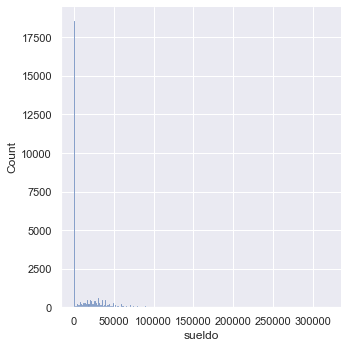

In [25]:
sns.displot(df_moms['sueldo'])

### En la gráfica anterior nos enfrentamos a la necesidad de eliminar outliers para realizar un análisis más ajustado a la realidad general de las madres

In [26]:
moms_sueldos_no_outliers = df_moms[df_moms['estado_laboral'].str.contains('Ocupados')].copy()
moms_sueldos_no_outliers = moms_sueldos_no_outliers[moms_sueldos_no_outliers['edad'] > 14]
moms_sueldos_no_outliers = moms_sueldos_no_outliers[moms_sueldos_no_outliers['sueldo'] > 0]

In [27]:
quantil_99 = moms_sueldos_no_outliers['sueldo'].quantile(0.99)
print(quantil_99)

moms_sueldos_no_outliers = moms_sueldos_no_outliers[moms_sueldos_no_outliers['sueldo'] < quantil_99]

quartil_1 = moms_sueldos_no_outliers['sueldo'].quantile(0.25)
quartil_3 = moms_sueldos_no_outliers['sueldo'].quantile(0.75)

iqr =  quartil_3 - quartil_1

moms_sueldos_no_outliers = moms_sueldos_no_outliers[moms_sueldos_no_outliers['sueldo'] < quartil_3 + 1.5 * iqr]

moms_sueldos_no_outliers = moms_sueldos_no_outliers[moms_sueldos_no_outliers['sueldo'] > quartil_1 - 1.5 * iqr]

120000.0


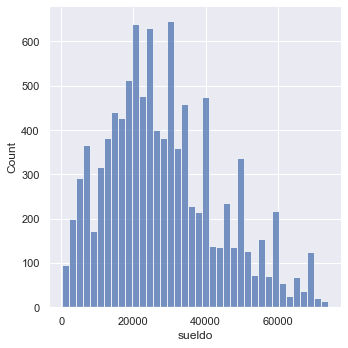

In [28]:
sns.displot(moms_sueldos_no_outliers['sueldo'])

### Sueldo por cantidad de hijos

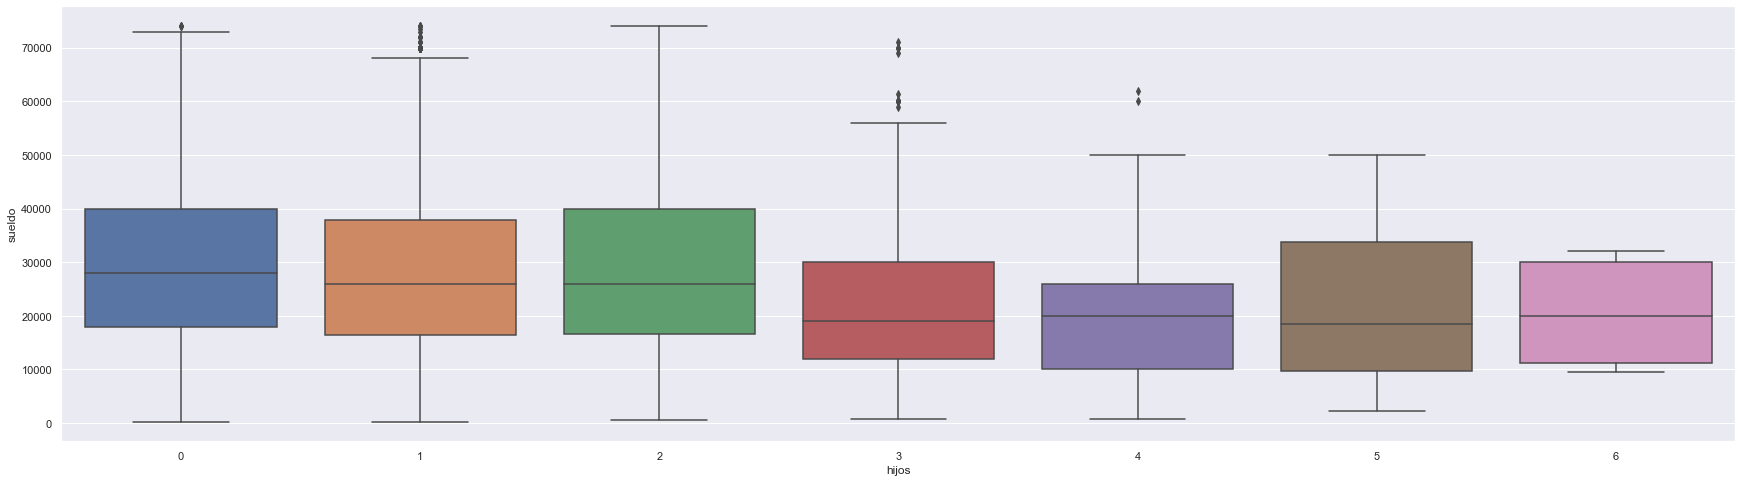

In [29]:
sns.boxplot(data=moms_sueldos_no_outliers, x='hijos', y='sueldo')

plt.show()

In [30]:
moms_sueldos_no_outliers[['edad', 'sueldo', 'hijos']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
edad,10087.0,44.854466,11.302478,19.0,36.0,45.0,54.0,84.0
sueldo,10087.0,28352.845742,15801.092222,300.0,17000.0,26000.0,38000.0,74000.0
hijos,10087.0,0.965401,0.985666,0.0,0.0,1.0,2.0,6.0


### Sueldo por ascendencia

<AxesSubplot:xlabel='ascendencia', ylabel='sueldo'>

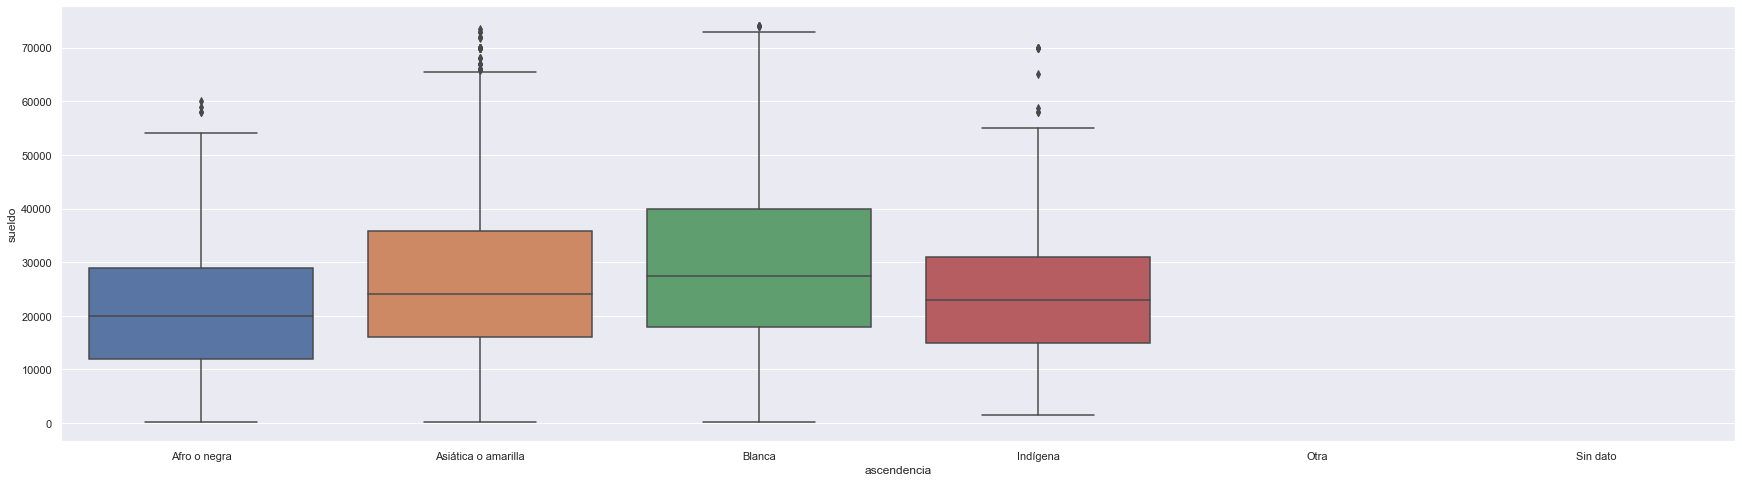

In [31]:
sns.boxplot(data=moms_sueldos_no_outliers, x='ascendencia', y='sueldo')

In [32]:
moms_sueldos_no_outliers.sample(5)

,id_hogar,sexo,edad,genero,ascendencia,parentesco,estado_laboral,nper,sueldo,busca_otro_trabajo,...,edu primaria,edu media,edu técnica,edu univ o simil,edu terciario no uni,edu posgrado,edu mag prof,parentesco_num,es_madre,hijos
16021,16609,2.0,39.0,Mujer,Blanca,Jefe/a de hogar,Ocupados,1.0,30000.0,No,...,"Sí, asistió","Sí, asistió",No asistió,"Sí, asistió",No asistió,No asistió,No asistió,6,madre,2
1962,10707,2.0,58.0,Mujer,Blanca,Jefe/a de hogar,Ocupados,1.0,12400.0,No,...,"Sí, asistió","Sí, asistió",No asistió,0.0,0.0,0.0,0.0,6,madre,1
90261,47128,2.0,36.0,Mujer,Blanca,Jefe/a de hogar,Ocupados,1.0,5500.0,Sí,...,"Sí, asistió",Asiste actualmente,"Sí, asistió",0.0,0.0,0.0,0.0,6,madre,2
28753,22379,2.0,28.0,Mujer,Blanca,Jefe/a de hogar,Ocupados,1.0,60000.0,No,...,"Sí, asistió","Sí, asistió",No asistió,"Sí, asistió",No asistió,No asistió,No asistió,6,madre,0
141351,49593,2.0,54.0,Mujer,Asiática o amarilla,Jefe/a de hogar,Ocupados,1.0,26000.0,No,...,"Sí, asistió","Sí, asistió",No asistió,0.0,0.0,0.0,0.0,6,madre,0


Tiene trabajo sí o no

label encoding y despues get dummies

variable target no columnas, necesitamos una sola columna. hacer encoding de eso

cross validation - 10 fold - testear que no haya overfitting, separa el dataset en k folds

standard scaler

pca scikit